### Data Loading and Pre processing

In [14]:
#import libraries
#pip install pandas
#pip install numpy
#pip install xgboost
#pip install torch torchvision
#pip install torchvision

import pandas as pd
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [5]:
# Load and preprocess data
data = pd.read_excel('data_daily.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['DayOfYear'] = data['Date'].dt.dayofyear

data.head()

,Date,Receipt_Count,DayOfWeek,Month,DayOfYear
0,2021-01-01,7564766,4,1,1
1,2021-01-02,7455524,5,1,2
2,2021-01-03,7095414,6,1,3
3,2021-01-04,7666163,0,1,4
4,2021-01-05,7771289,1,1,5


### Model Training and Evaluation

In [6]:
# Splitting dataset into training and testing
total_size = len(data)
train_size = int(0.9 * total_size)
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:]


In [7]:
# XGBoost Model
X_train_xgb = train_data[['DayOfWeek', 'Month', 'DayOfYear']]
y_train_xgb = train_data['Receipt_Count']
X_val_xgb = val_data[['DayOfWeek', 'Month', 'DayOfYear']]
y_val_xgb = val_data['Receipt_Count']

# Initialize and train the XGBoost model with manually tuned hyperparameters
xgb_model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror')
xgb_model.fit(X_train_xgb, y_train_xgb)

# Neural Network Model
receipts = torch.tensor(data['Receipt_Count'].values, dtype=torch.float32)
receipts_normalized = (receipts - receipts.mean()) / receipts.std()
X_nn = torch.tensor(data[['DayOfYear']].values, dtype=torch.float32)
y_nn = receipts_normalized.unsqueeze(1)

# Define the Neural Network
class AdvancedNeuralNetwork(nn.Module):
    def __init__(self):
        super(AdvancedNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 64)
        self.relu1 = nn.LeakyReLU()
        self.norm1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 128)
        self.relu2 = nn.LeakyReLU()
        self.norm2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.relu3 = nn.LeakyReLU()
        self.norm3 = nn.BatchNorm1d(64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.norm1(self.relu1(self.layer1(x)))
        x = self.norm2(self.relu2(self.layer2(x)))
        x = self.norm3(self.relu3(self.layer3(x)))
        x = self.output(x)
        return x


# Train Neural Network
nn_model = AdvancedNeuralNetwork()
optimizer = optim.Adam(nn_model.parameters(), lr=0.1)
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_nn[:train_size], y_nn[:train_size]), batch_size=32, shuffle=True)

for epoch in range(1000):  # Number of epochs
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Linear Regression Model
from sklearn.preprocessing import StandardScaler
X_train_features = train_data[['DayOfYear', 'DayOfWeek', 'Month']].values
y_train_lr = train_data['Receipt_Count'].values.reshape(-1, 1)
X_val_features = val_data[['DayOfYear', 'DayOfWeek', 'Month']].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

# Adding the bias term 
X_train_lr = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_val_lr = np.c_[np.ones((X_val_scaled.shape[0], 1)), X_val_scaled]

# Linear Regression using Gradient Descent
weights = np.random.randn(X_train_lr.shape[1], 1) * 0.01  # Small initial weights
learning_rate = 0.01  # Adjusted learning rate
num_iterations = 1000

for iteration in range(num_iterations):
    predictions = X_train_lr.dot(weights)
    errors = predictions - y_train_lr
    gradients = 2/X_train_lr.shape[0] * X_train_lr.T.dot(errors)
    weights -= learning_rate * gradients



In [8]:
# Predictions for Validation Set
X_val_xgb_processed = val_data[['DayOfWeek', 'Month', 'DayOfYear']]
xgb_predictions = xgb_model.predict(X_val_xgb_processed)

X_val_nn = torch.tensor(val_data[['DayOfYear']].values, dtype=torch.float32)
nn_predictions = nn_model(X_val_nn).detach().numpy().flatten() * receipts.std().item() + receipts.mean().item()

X_val_lr_processed = np.c_[np.ones((val_data.shape[0], 1)), val_data[['DayOfYear', 'DayOfWeek', 'Month']].values]
lr_predictions = X_val_lr.dot(weights).flatten()

# Combining Predictions in a DataFrame
predictions_df = pd.DataFrame({
    'Date': val_data['Date'],
    'XGBoost_Predictions': xgb_predictions,
    'Neural_Network_Predictions': nn_predictions,
    'Linear_Regression_Predictions': lr_predictions
})

# Display the DataFrame
print(predictions_df.head())


          Date  XGBoost_Predictions  Neural_Network_Predictions  \
328 2021-11-25            9874064.0                   7347065.0   
329 2021-11-26            9887612.0                   7417547.0   
330 2021-11-27            9930922.0                   7488086.0   
331 2021-11-28            9764644.0                   7558754.0   
332 2021-11-29            9640631.0                   7629423.0   

     Linear_Regression_Predictions  
328                   9.824208e+06  
329                   9.831096e+06  
330                   9.837985e+06  
331                   9.844874e+06  
332                   9.829263e+06  


In [9]:
from sklearn.metrics import mean_squared_error


# XGBoost MSE
xgb_mse = mean_squared_error(y_val_xgb, xgb_predictions)

# Neural Network MSE
y_val_tensor = torch.tensor(y_val_xgb.values, dtype=torch.float32)
nn_mse = mean_squared_error(y_val_tensor, nn_predictions)

# Linear Regression MSE
lr_mse = mean_squared_error(y_val_xgb, lr_predictions)

# Print the MSE for each model
print("XGBoost MSE:", xgb_mse)
print("Neural Network MSE:", nn_mse)
print("Linear Regression MSE:", lr_mse)

XGBoost MSE: 116947468716.08109
Neural Network MSE: 2517563000000.0
Linear Regression MSE: 74389659691.84325


### Predicting Values for 2022 and Ensemble approach

In [10]:
# Preparing the data for 2022
df_2022 = pd.DataFrame({'Date': pd.date_range(start='2022-01-01', end='2022-12-31')})
df_2022['DayOfWeek'] = df_2022['Date'].dt.dayofweek
df_2022['Month'] = df_2022['Date'].dt.month
df_2022['DayOfYear'] = df_2022['Date'].dt.dayofyear



In [11]:
# XGBoost Predictions for 2022
X_2022_xgb = df_2022[['DayOfWeek', 'Month', 'DayOfYear']]
xgb_predictions_2022 = xgb_model.predict(X_2022_xgb)

# Neural Network Predictions for 2022
X_2022_nn = torch.tensor(df_2022[['DayOfYear']].values, dtype=torch.float32)
nn_model.eval()
with torch.no_grad():
    nn_predictions_2022 = nn_model(X_2022_nn).numpy().flatten() * receipts.std().item() + receipts.mean().item()

# Linear Regression Predictions for 2022
X_2022_lr = np.c_[np.ones((df_2022.shape[0], 1)), scaler.transform(df_2022[['DayOfYear', 'DayOfWeek', 'Month']].values)]
lr_predictions_2022 = X_2022_lr.dot(weights).flatten()

# Averaging the predictions
average_predictions_2022 = (xgb_predictions_2022 + nn_predictions_2022 + lr_predictions_2022) / 3

# Creating a DataFrame for the predictions
predictions_df_2022 = pd.DataFrame({
    'Date': df_2022['Date'],
    'XGBoost_Predictions': xgb_predictions_2022,
    'Neural_Network_Predictions': nn_predictions_2022,
    'Linear_Regression_Predictions': lr_predictions_2022,
    'Average_Predictions': average_predictions_2022
})

# Display the DataFrame
print(predictions_df_2022.head())


        Date  XGBoost_Predictions  Neural_Network_Predictions  \
0 2022-01-01            7474157.5                   7235163.0   
1 2022-01-02            7393628.5                   7242460.0   
2 2022-01-03            7542074.0                   7249757.0   
3 2022-01-04            7558970.0                   7257217.5   
4 2022-01-05            7639347.5                   7264882.0   

   Linear_Regression_Predictions  Average_Predictions  
0                   7.586545e+06         7.431955e+06  
1                   7.593434e+06         7.409841e+06  
2                   7.577822e+06         7.456551e+06  
3                   7.584711e+06         7.466966e+06  
4                   7.591600e+06         7.498610e+06  


In [12]:
# Calculate the difference between Dec 31, 2021, and Jan 1, 2021
dec_31_2021_value = data.loc[data['Date'] == '2021-12-31', 'Receipt_Count'].iloc[0]
jan_1_2021_value = data.loc[data['Date'] == '2021-01-01', 'Receipt_Count'].iloc[0]
difference = dec_31_2021_value - jan_1_2021_value

# Add this difference to all the average predicted values in 2022
predictions_df_2022['Approximate_Average_Predictions'] = predictions_df_2022['Average_Predictions'] + difference

# Display the DataFrame with adjusted predictions
print(predictions_df_2022.head())
predictions_df_2022.to_excel('Ensemble_Predict.xlsx', index=False)

        Date  XGBoost_Predictions  Neural_Network_Predictions  \
0 2022-01-01            7474157.5                   7235163.0   
1 2022-01-02            7393628.5                   7242460.0   
2 2022-01-03            7542074.0                   7249757.0   
3 2022-01-04            7558970.0                   7257217.5   
4 2022-01-05            7639347.5                   7264882.0   

   Linear_Regression_Predictions  Average_Predictions  \
0                   7.586545e+06         7.431955e+06   
1                   7.593434e+06         7.409841e+06   
2                   7.577822e+06         7.456551e+06   
3                   7.584711e+06         7.466966e+06   
4                   7.591600e+06         7.498610e+06   

   Approximate_Average_Predictions  
0                     1.007838e+07  
1                     1.005626e+07  
2                     1.010297e+07  
3                     1.011339e+07  
4                     1.014503e+07  


### Ensemble Prediction Plot for 2022

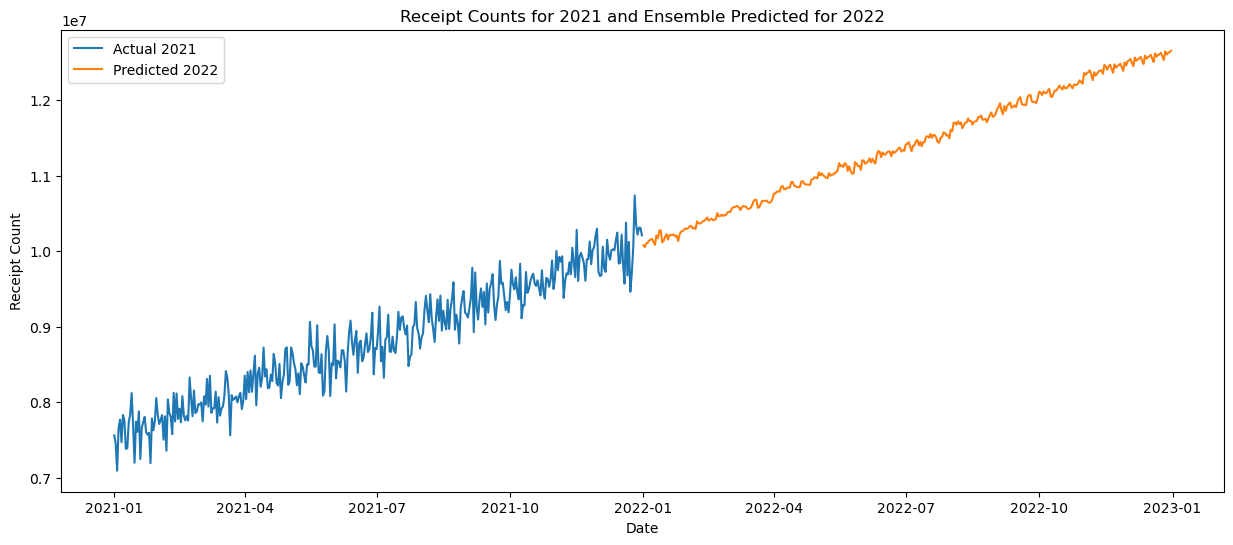

In [15]:
# Extract actual values for 2021
data_2021 = data[data['Date'].dt.year == 2021]

# Prepare the combined DataFrame
combined_df = pd.concat([data_2021[['Date', 'Receipt_Count']], predictions_df_2022[['Date', 'Approximate_Average_Predictions']]], ignore_index=True)
combined_df.rename(columns={'Receipt_Count': 'Actual_2021', 'Approximate_Average_Predictions': 'Predicted_2022'}, inplace=True)

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(combined_df['Date'], combined_df['Actual_2021'], label='Actual 2021')
plt.plot(combined_df['Date'], combined_df['Predicted_2022'], label='Predicted 2022')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.title('Receipt Counts for 2021 and Ensemble Predicted for 2022')
plt.legend()
plt.show()


### Comparing the predictions of all the 3 models

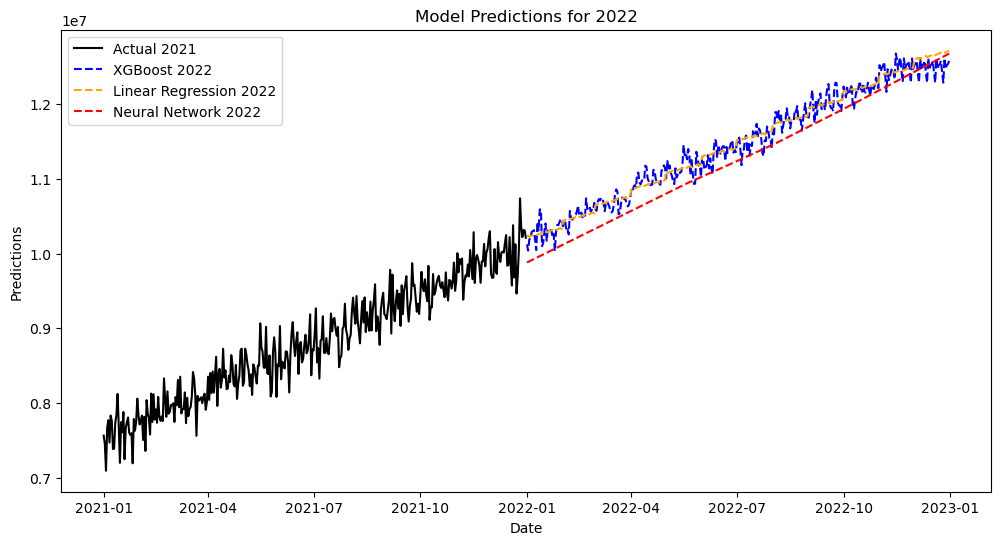

In [16]:
actual_2021 = data[data['Date'].dt.year == 2021]['Receipt_Count']

# Creating a date range for 2022 for plotting
dates_2022 = pd.date_range(start='2022-01-01', end='2022-12-31')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data[data['Date'].dt.year == 2021]['Date'], actual_2021, label='Actual 2021', color='black')
plt.plot(dates_2022, xgb_predictions_2022+difference, label='XGBoost 2022', linestyle='--', color='blue')
plt.plot(dates_2022, lr_predictions_2022+difference, label='Linear Regression 2022', linestyle='--', color='orange')
plt.plot(dates_2022, nn_predictions_2022+difference, label='Neural Network 2022', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Predictions')
plt.title('Model Predictions for 2022')
plt.legend()
plt.show()

### Algorithm which can predict the approximate number of the scanned receipts for each month of 2022.


Enter the month (number from 1 to 12 or name): 9
Total approx. predictions for the specified month in 2022: 358441892


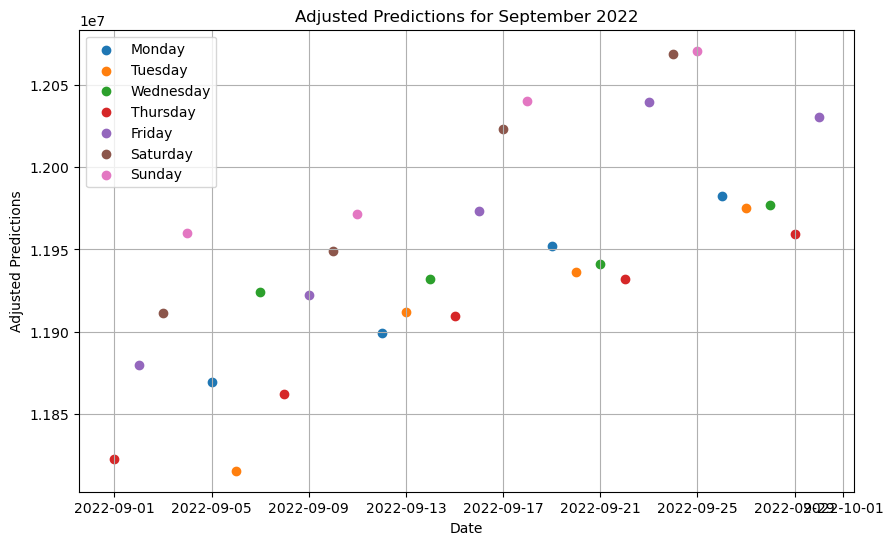

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def get_month_sum_and_plot(predictions_df, year=2022):
    # Prompt user for the month
    month_input = input("Enter the month (number from 1 to 12 or name): ")

    # Convert month name to number if necessary
    try:
        month = int(month_input)
    except ValueError:
        try:
            month = pd.to_datetime(month_input, format='%B').month
        except ValueError:
            print("Invalid month. Please enter a valid month number or name.")
            return

    # Check if month is in valid range
    if month not in range(1, 13):
        print("Invalid month. Please enter a month number between 1 and 12.")
        return

    # Filter predictions for the specified month and year
    monthly_predictions = predictions_df[(predictions_df['Date'].dt.year == year) & 
                                         (predictions_df['Date'].dt.month == month)]

    # Calculate the sum of adjusted predictions and round it
    total_prediction = round(monthly_predictions['Approximate_Average_Predictions'].sum())

    # Print the total sum
    print(f"Total approx. predictions for the specified month in 2022: {total_prediction}")

    # Prepare for plotting
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    colors = list(mcolors.TABLEAU_COLORS.values())  # Or any other color map

    # Scatter plot for day-wise predictions
    plt.figure(figsize=(10, 6))
    for i, day in enumerate(days):
        day_data = monthly_predictions[monthly_predictions['Date'].dt.dayofweek == i]
        plt.scatter(day_data['Date'], day_data['Approximate_Average_Predictions'], color=colors[i], label=day)

    plt.xlabel('Date')
    plt.ylabel('Adjusted Predictions')
    month_name = pd.to_datetime(f"{year}-{month}-01").strftime('%B')  # Get month name from month number
    plt.title(f'Adjusted Predictions for {month_name} {year}')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the function
get_month_sum_and_plot(predictions_df_2022)
